## install dependencies

In [1]:
!pip install -U datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


## imports

In [2]:
import os
import re
import json
import shutil
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

import torch
import transformers
from datasets import load_dataset
from transformers import DonutProcessor, VisionEncoderDecoderModel, VisionEncoderDecoderConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## define paths

In [3]:
torch.manual_seed(0)
 
# define paths
base_path = Path("./ExtractionData/")
metadata_path = base_path.joinpath("annotations/svk_id.json")
image_path = base_path.joinpath("images/svk_id/")

## format dataset files

In [4]:
raw_metadata = json.load(open(metadata_path))
raw_metadata_list = list(raw_metadata["_via_img_metadata"].values())

metadata_list = []
for curr_raw_metadata in tqdm(raw_metadata_list):
    filename = curr_raw_metadata["filename"]
    ocr_regions = curr_raw_metadata["regions"]
    ocr_text = {c["region_attributes"]["field_name"]: c["region_attributes"]["value"] for c in ocr_regions[2:-1]}
    metadata_list.append({"file_name": filename, "text": ocr_text})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 351871.14it/s]


In [5]:
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

## load dataset

In [6]:
# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")
 
print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 100 images
Dataset features are: dict_keys(['image', 'text'])


### visualize dataset sample

Random sample is 94
OCR text is {'name': 'Urh', 'surname': 'Kobav', 'gender': 'M', 'nationality': 'SVK', 'id_number': '980510/6897', 'number': 'QZ441042', 'issue_place': 'Holíč', 'birth_date': '10.05.1998', 'expiry_date': '08.05.2025', 'issue_date': '08.05.2015'}


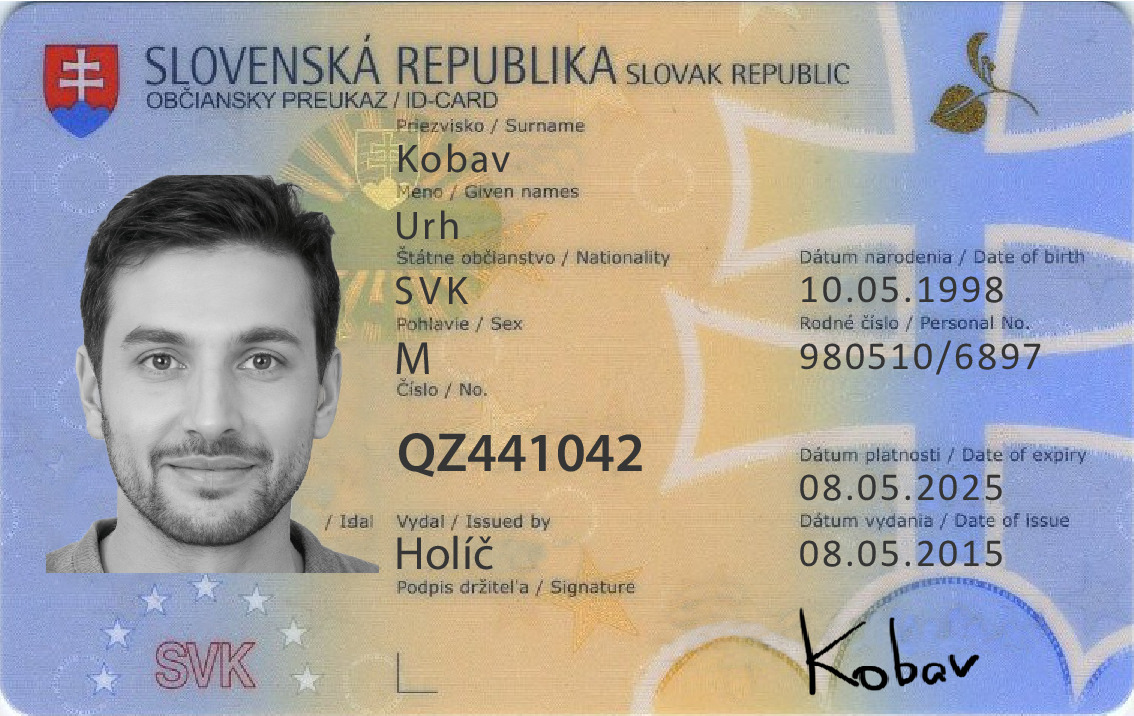

In [7]:
random_sample = random.randint(0, len(dataset))
 
print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image']

### get dataset image dimensions

In [8]:
np.mean([d["image"].size for d in dataset], axis=0)

array([1134.,  716.])

## process dataset for DONUT training

In [9]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer
 
def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj
 
 
def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = sample["text"]
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}
 
proc_dataset = dataset.map(preprocess_documents_for_donut)
 
print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Sample: <s><s_surname>Katanović</s_surname><s_number>UF650953</s_number><s_nationality>SVK</s_nationality><s_name>Melanija</s_name><s_issue_place>Šaľa</s_issue_place><s_issue_date>29.05.2016</s_issue_date><s_id_number>711218/1465</s_id_number><s_gender>F</s_gender><s_expiry_date>29.05.2026</s_expiry_date><s_birth_date>18.12.1971</s_birth_date></s>
New special tokens: ['<s_surname>', '</s_surname>', '<s_number>', '</s_number>', '<s_nationality>', '</s_nationality>', '<s_name>', '</s_name>', '<s_issue_place>', '</s_issue_place>', '<s_issue_date>', '</s_issue_date>', '<s_id_number>', '</s_id_number>', '<s_gender>', '</s_gender>', '<s_expiry_date>', '</s_expiry_date>', '<s_birth_date>', '</s_birth_date>', '<s>', '</s>']


In [10]:
# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
 
# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})
 
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [1134, 716] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/transformers/models/donut/processing_donut.py:190: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [11]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
 
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)
 
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}
 
# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [12]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 90
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 10
    })
})


## define DONUT model

In [13]:
# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
 
# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))
 
# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

New embedding size: Embedding(57545, 1024)


## train DONUT model

### setup training hyperparameters

In [14]:
# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir="training_output",
    num_train_epochs=15,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=False,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="steps",
    save_strategy="epoch",
    predict_with_generate=True,
    report_to="tensorboard",
    push_to_hub=False,
)
 
# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"]
)

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### start model training

In [15]:
# Start training
trainer.train()

Step,Training Loss,Validation Loss
100,3.349500,0.415659
200,0.224400,1.134356
300,0.082000,0.340864
400,0.043800,0.330466
500,0.040200,0.367946
600,0.019300,0.323869


Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


TrainOutput(global_step=675, training_loss=0.5575668734974332, metrics={'train_runtime': 32555.1701, 'train_samples_per_second': 0.041, 'train_steps_per_second': 0.021, 'total_flos': 2.78929374782567e+18, 'train_loss': 0.5575668734974332, 'epoch': 15.0})

##

## run trained model on test set

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Reference:
 {'surname': 'Mitkovski', 'number': 'YC238633', 'nationality': 'SVK', 'name': 'Sead', 'issue_place': 'Dolný Kubín', 'issue_date': '13.10.2014', 'id_number': '761101/3512', 'gender': 'M', 'expiry_date': '13.10.2024', 'birth_date': '01.11.1976'}
Prediction:
 {'surname': 'Mitkovski', 'number': 'YC238633', 'nationality': 'SVK', 'name': 'Sead', 'issue_place': 'Dolný Kubín', 'issue_date': '13.10.2014', 'id_number': '761101/3512', 'gender': 'M', 'expiry_date': '13.10.2024', 'birth_date': '01.11.1976'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


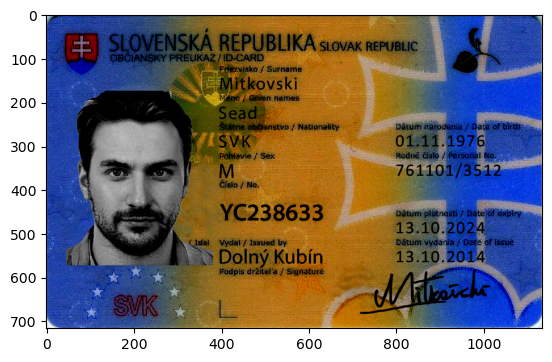

In [16]:
# hidde logs
transformers.logging.disable_default_handler()
 
# Load our model from Hugging Face
# processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
# model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")
 
# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 10)]
 
def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
 
    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
 
    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
 
    # load reference target
    target = processor.token2json(sample["target_sequence"])
    return prediction, target
 
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
plt.imshow(np.array(test_sample["pixel_values"]).transpose(1,2,0));

## run model on a random sample from the internet

In [17]:
blind_test_image = Image.open("./test.jpg").convert('RGB')

In [18]:
blind_test_image_pixel_values = processor(
            blind_test_image, random_padding=0, return_tensors="pt"
        ).pixel_values.squeeze()

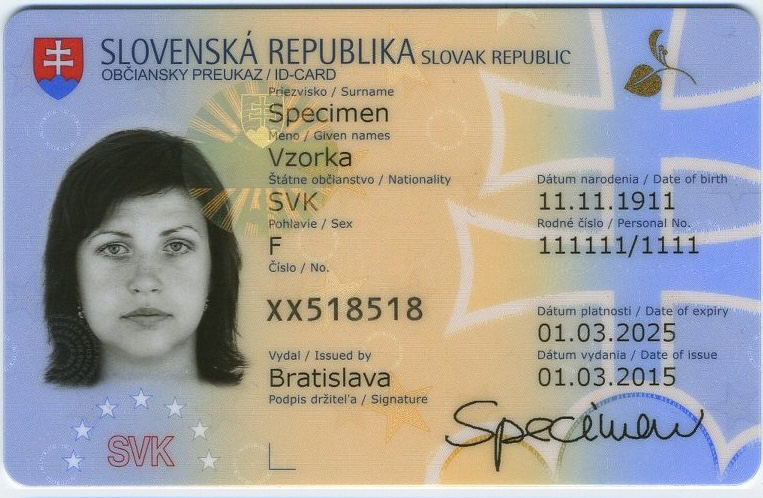

In [19]:
blind_test_image

In [20]:
# prepare inputs
pixel_values = torch.tensor(blind_test_image_pixel_values).unsqueeze(0)
task_prompt = "<s>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

# run inference
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

# process output
prediction = processor.batch_decode(outputs.sequences)[0]
prediction = processor.token2json(prediction)
print(f"Prediction:\n {prediction}")

/var/folders/bc/4d78jrn15m924n8pt76chnf40000gr/T/ipykernel_3046/403417652.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(blind_test_image_pixel_values).unsqueeze(0)


Prediction:
 {'surname': 'Specimen', 'number': 'XX518518', 'nationality': 'SVK', 'name': 'Vzorka', 'issue_place': 'Bratislava Podpis drzitelán / Siignature', 'issue_date': '01.03.2015', 'id_number': '111111/1111', 'gender': 'F', 'expiry_date': '01.03.2025', 'birth_date': '11.11.1911'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


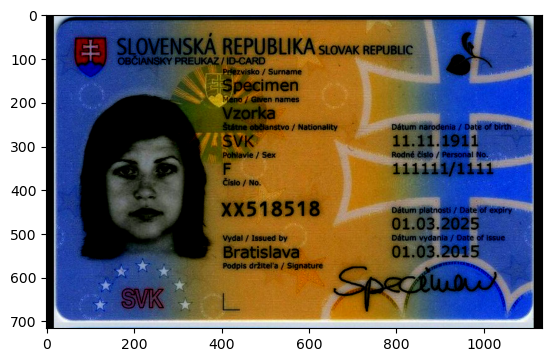

In [21]:
plt.imshow(np.array(blind_test_image_pixel_values).transpose(1,2,0));